In [2]:
import pandas as pd
from dfply import *
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D,Dense,Flatten
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.decomposition import PCA

print(tf.__version__)

if tf.test.gpu_device_name():
   print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")
  

2.1.0
Default GPU Device: /device:GPU:0


In [4]:
df = pd.read_csv("E:\\ProjectData\\ERAU-REU\\Project-Drone-Behavior\\behavior-captures\\behavior-signal-multiple-processed.csv")

In [6]:
#plot = df.plot(legend=False)
#plot.figure.savefig("E:\\ProjectData\\ERAU-REU\\Project-Drone-Behavior\\plots\\allplot.png")

In [8]:
#plot = videoDf.plot(legend=False)
#plot.figure.savefig("E:\\ProjectData\\ERAU-REU\\Project-Drone-Behavior\\plots\\allVideoPlot.png")

In [10]:
df >>= mutate(drone_present = case_when([df.behavior == 'surround','yes'],
[df.behavior == 'straight','yes'],
[df.behavior == 'noise','no']))
presence_labs = df['drone_present']

In [12]:
values = np.array(presence_labs)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

y.shape

(3200, 2)

In [14]:
x = df.drop(['behavior','signal','multiple','drone_present'],axis=1).values

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [18]:
model = keras.Sequential(name='test')
model.add(Dense(64, activation='relu', input_shape=(1280,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [20]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(1280,))
model.summary()

Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                81984     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 84,130
Trainable params: 84,130
Non-trainable params: 0
_________________________________________________________________


In [22]:
fit1 = model.fit(x = x_train,
        y = y_train, 
        epochs = 100,
        batch_size = 32,
        validation_split = .2,
        verbose=True)

Train on 2048 samples, validate on 512 samples
Epoch 1/100
2048/2048 [==============================] - 0s 165us/sample - loss: 0.3437 - accuracy: 0.8718 - val_loss: 0.3437 - val_accuracy: 0.8867
Epoch 2/100
2048/2048 [==============================] - 0s 177us/sample - loss: 0.3430 - accuracy: 0.8713 - val_loss: 0.3429 - val_accuracy: 0.8867
Epoch 3/100
2048/2048 [==============================] - 0s 160us/sample - loss: 0.3412 - accuracy: 0.8721 - val_loss: 0.3423 - val_accuracy: 0.8867
Epoch 4/100
2048/2048 [==============================] - 0s 171us/sample - loss: 0.3409 - accuracy: 0.8718 - val_loss: 0.3415 - val_accuracy: 0.8867
Epoch 5/100
2048/2048 [==============================] - 0s 169us/sample - loss: 0.3395 - accuracy: 0.8706 - val_loss: 0.3401 - val_accuracy: 0.8867
Epoch 6/100
2048/2048 [==============================] - 0s 163us/sample - loss: 0.3384 - accuracy: 0.8721 - val_loss: 0.3386 - val_accuracy: 0.8867
Epoch 7/100
2048/2048 [==============================] - 0s

In [24]:
prediction = model.predict(x_test)
prediction_df = pd.DataFrame(prediction, columns=['prob_present','prob_not_present']) 

In [26]:
y_test = pd.DataFrame(y_test,columns=['present','not_present'])

y_pred = y_test >> bind_cols(prediction_df)

y_pred >>= mutate(actual = case_when([y_pred.present == 1, 'present'],
[y_pred.not_present == 1, 'not_present']),
predicted = case_when([y_pred.prob_present > y_pred.prob_not_present, 'present'],
[y_pred.prob_present < y_pred.prob_not_present, 'not_present']))

y_pred >>= mutate(correct = case_when([y_pred.actual == y_pred.predicted, 'yes'],
[y_pred.actual != y_pred.predicted, 'no']))
y_pred


,present,not_present,prob_present,prob_not_present,actual,predicted,correct
0,0.0,1.0,0.284946,0.720295,not_present,not_present,yes
1,0.0,1.0,0.166026,0.834380,not_present,not_present,yes
2,1.0,0.0,0.143266,0.853280,present,not_present,no
3,0.0,1.0,0.105402,0.895531,not_present,not_present,yes
4,1.0,0.0,0.992360,0.007949,present,present,yes
...,...,...,...,...,...,...,...
635,1.0,0.0,0.104574,0.882892,present,not_present,no
636,0.0,1.0,0.088280,0.909165,not_present,not_present,yes
637,0.0,1.0,0.147159,0.850736,not_present,not_present,yes
638,1.0,0.0,0.972684,0.028254,present,present,yes


In [28]:
small_df = df[df.columns[0:256]]
small_df >>= bind_cols(df.drone_present)

presence_labs = small_df['drone_present']

values = np.array(presence_labs)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

x = small_df.drop(['drone_present'],axis=1).values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = keras.Sequential(name='test')
model.add(Dense(64, activation='relu', input_shape=(256,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(256,))
model.summary()

fit1 = model.fit(x = x_train,
        y = y_train, 
        epochs = 100,
        batch_size = 32,
        validation_split = .2,
        verbose=True)

prediction = model.predict(x_test)
prediction_df = pd.DataFrame(prediction, columns=['prob_present','prob_not_present']) 

y_test = pd.DataFrame(y_test,columns=['present','not_present'])

y_pred = y_test >> bind_cols(prediction_df)

y_pred >>= mutate(actual = case_when([y_pred.present == 1, 'present'],
[y_pred.not_present == 1, 'not_present']),
predicted = case_when([y_pred.prob_present > y_pred.prob_not_present, 'present'],
[y_pred.prob_present < y_pred.prob_not_present, 'not_present']))

y_pred >>= mutate(correct = case_when([y_pred.actual == y_pred.predicted, 'yes'],
[y_pred.actual != y_pred.predicted, 'no']))
y_pred



Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 66        
Total params: 18,594
Trainable params: 18,594
Non-trainable params: 0
_________________________________________________________________
Train on 2048 samples, validate on 512 samples
Epoch 1/100
2048/2048 [==============================] - 1s 374us/sample - loss: 0.6890 - accuracy: 0.5493 - val_loss: 0.6844 - val_accuracy: 0.6025
Epoch 2/100
2048/2048 [==============================] - 0s 106us/sample - loss: 0.6826 - accuracy: 0.5906 - val_loss: 0.6784 - val_accuracy: 0.6035
Epoch 3/100
2048/2048 [====================

,present,not_present,prob_present,prob_not_present,actual,predicted,correct
0,0.0,1.0,0.258716,0.733048,not_present,not_present,yes
1,1.0,0.0,0.705851,0.299395,present,present,yes
2,0.0,1.0,0.268370,0.728089,not_present,not_present,yes
3,0.0,1.0,0.233127,0.769930,not_present,not_present,yes
4,0.0,1.0,0.277663,0.727295,not_present,not_present,yes
...,...,...,...,...,...,...,...
635,1.0,0.0,0.744946,0.260119,present,present,yes
636,0.0,1.0,0.270833,0.721586,not_present,not_present,yes
637,0.0,1.0,0.046991,0.930981,not_present,not_present,yes
638,0.0,1.0,0.187823,0.794977,not_present,not_present,yes


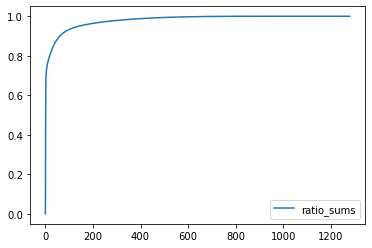

In [30]:
x = df.drop(['behavior','signal','multiple','drone_present'],axis=1).values

pca = decomposition.PCA(n_components=1280)
pca.fit(x)
pca_x = pca.transform(x)

variance = []
for i in range(1280):
    variance.append(sum(pca.explained_variance_ratio_[0:i]))

variance = pd.DataFrame(variance,columns=['ratio_sums'])
variance.plot()

In [32]:
presence_labs = df['drone_present']

values = np.array(presence_labs)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

x = df.drop(['behavior','signal','multiple','drone_present'],axis=1).values

pca = decomposition.PCA(n_components=200)
pca.fit(x)
x = pca.transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = keras.Sequential(name='test')
model.add(Dense(64, activation='relu', input_shape=(200,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(200,))
model.summary()

fit1 = model.fit(x = x_train,
        y = y_train, 
        epochs = 100,
        batch_size = 32,
        validation_split = .2,
        verbose=True)

prediction = model.predict(x_test)
prediction_df = pd.DataFrame(prediction, columns=['prob_present','prob_not_present']) 

y_test = pd.DataFrame(y_test,columns=['present','not_present'])

y_pred = y_test >> bind_cols(prediction_df)

y_pred >>= mutate(actual = case_when([y_pred.present == 1, 'present'],
[y_pred.not_present == 1, 'not_present']),
predicted = case_when([y_pred.prob_present > y_pred.prob_not_present, 'present'],
[y_pred.prob_present < y_pred.prob_not_present, 'not_present']))

y_pred >>= mutate(correct = case_when([y_pred.actual == y_pred.predicted, 'yes'],
[y_pred.actual != y_pred.predicted, 'no']))
y_pred


Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                12864     
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 66        
Total params: 15,010
Trainable params: 15,010
Non-trainable params: 0
_________________________________________________________________
Train on 2048 samples, validate on 512 samples
Epoch 1/100
2048/2048 [==============================] - 1s 402us/sample - loss: 0.6898 - accuracy: 0.5896 - val_loss: 0.6791 - val_accuracy: 0.7119
Epoch 2/100
2048/2048 [==============================] - 0s 166us/sample - loss: 0.6741 - accuracy: 0.7739 - val_loss: 0.6641 - val_accuracy: 0.8457
Epoch 3/100
2048/2048 [====================

,present,not_present,prob_present,prob_not_present,actual,predicted,correct
0,0.0,1.0,0.139132,0.853050,not_present,not_present,yes
1,1.0,0.0,0.987247,0.013593,present,present,yes
2,1.0,0.0,0.978789,0.023185,present,present,yes
3,0.0,1.0,0.147914,0.850647,not_present,not_present,yes
4,0.0,1.0,0.173664,0.821316,not_present,not_present,yes
...,...,...,...,...,...,...,...
635,0.0,1.0,0.164843,0.841807,not_present,not_present,yes
636,1.0,0.0,0.985212,0.015664,present,present,yes
637,1.0,0.0,0.985465,0.015096,present,present,yes
638,0.0,1.0,0.171570,0.812368,not_present,not_present,yes
